In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [2]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [5]:
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import HeatMap
import shap
import warnings
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_excel('housing.xlsx')

In [7]:
data.head()

,county,city,zip,street,price,br,lsqft,bsqft,year,date,long,lat
0,Santa Clara county,Willow Glen,95125.0,1191 Laurie Avenue,675000,2.0,5663.0,1848.0,1938.0,2004-04-11,-121.895300,37.295461
1,Alameda County,Emeryville,94608.0,4 Anchor Drive \#F343,360000,1.0,NaN,660.0,1973.0,2005-07-17,-122.307378,37.837279
2,Alameda county,Emeryville,94608.0,1200 65th Street #226,425000,NaN,NaN,NaN,NaN,2003-06-01,NaN,NaN
3,Alameda County,Fremont,94536.0,37548 Summer Holly Common,609000,4.0,3877.0,1866.0,1997.0,2004-01-18,-121.994332,37.562218
4,Contra Costa County,Richmond,94801.0,666 5th Street,390000,4.0,4480.0,1025.0,1992.0,2006-01-29,-122.364390,37.941948


In [8]:
df = pd.DataFrame(data)

In [9]:
# Introduce missing values (as mentioned in the proposal)
for col in ['br', 'lsqft', 'bsqft', 'year']:
    df.loc[df.sample(frac=0.1).index, col] = np.nan

In [10]:
# 1. Exploratory Data Analysis (EDA)
print("=== Initial Data Overview ===")
print(f"Dataset shape: {df.shape}")
print("\nMissing values per column:")
print(df.isnull().sum())


=== Initial Data Overview ===
Dataset shape: (20000, 12)

Missing values per column:
county       0
city         0
zip          3
street       0
price        0
br        5419
lsqft     5079
bsqft     4657
year      5151
date         0
long      1896
lat       1896
dtype: int64


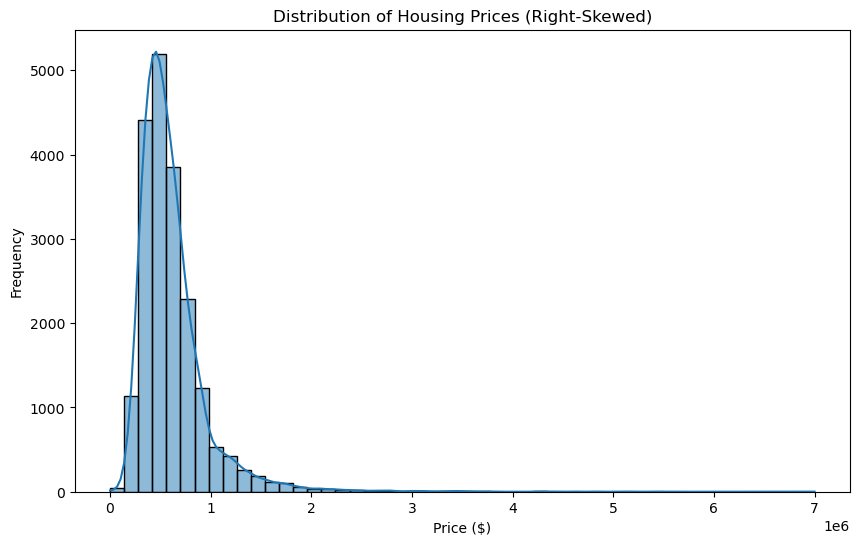

In [11]:
# Visualize price distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True, bins=50)
plt.title('Distribution of Housing Prices (Right-Skewed)')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()


In [12]:
# 2. Data Preprocessing
# Outlier treatment - Winsorization
def winsorize_series(series, lower=0.05, upper=0.95):
    lower_bound = series.quantile(lower)
    upper_bound = series.quantile(upper)
    return series.clip(lower_bound, upper_bound)

df['price'] = winsorize_series(df['price'])

In [13]:
# Compare imputation methods
# Method 1: Simple mean/median imputation
df_mean_imputed = df.copy()
for col in ['br', 'lsqft', 'bsqft', 'year']:
    if col == 'br':  # bedrooms are discrete
        df_mean_imputed[col].fillna(df_mean_imputed[col].median(), inplace=True)
    else:
        df_mean_imputed[col].fillna(df_mean_imputed[col].mean(), inplace=True)

In [14]:
# Method 2: k-NN imputation
imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = df.copy()
numeric_cols = ['br', 'lsqft', 'bsqft', 'year', 'lat', 'long']
df_knn_imputed[numeric_cols] = imputer.fit_transform(df_knn_imputed[numeric_cols])

In [15]:
# 3. Geospatial Feature Engineering
# Define key landmarks in the Bay Area (coordinates are approximate)
landmarks = {
    'Palo_Alto': (37.4419, -122.1430),  # Stanford/tech hub
    'SF_Downtown': (37.7749, -122.4194),  # San Francisco downtown
    'Oakland': (37.8044, -122.2711),  # Oakland city center
    'Googleplex': (37.4220, -122.0841),  # Google HQ
    'Apple_Park': (37.3346, -122.0090)   # Apple HQ
}

# Calculate distances to each landmark
for name, coords in landmarks.items():
    df_knn_imputed[f'dist_to_{name}'] = np.sqrt(
        (df_knn_imputed['lat'] - coords[0])**2 + 
        (df_knn_imputed['long'] - coords[1])**2
    )


In [16]:
# Neighborhood clustering using DBSCAN
coords = df_knn_imputed[['lat', 'long']].values
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# DBSCAN clustering
dbscan = DBSCAN(eps=0.2, min_samples=10)
df_knn_imputed['neighborhood_cluster'] = dbscan.fit_predict(coords_scaled)


In [17]:
# 4. Interactive Map Visualization
# Create a base map centered on the Bay Area
bay_area_map = folium.Map(location=[37.7749, -122.4194], zoom_start=10)

# Add heatmap of prices
heat_data = [[row['lat'], row['long'], row['price']] for index, row in df_knn_imputed.iterrows()]
HeatMap(heat_data, radius=10).add_to(bay_area_map)

# Add landmark markers
for name, coords in landmarks.items():
    folium.Marker(
        location=coords,
        popup=name,
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(bay_area_map)

# Save the map
bay_area_map.save('bay_area_housing_heatmap.html')

In [18]:
# 5. Predictive Modeling
# Prepare data for modeling
X = df_knn_imputed.drop(['price', 'street', 'zip'], axis=1)  # Drop identifier columns
y = df_knn_imputed['price']

# One-hot encode categorical variables
categorical_cols = ['county', 'city']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])


In [19]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Define models to test
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1),
    'Ridge Regression': Ridge(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}


In [21]:
# First, let's check the data types in your DataFrame
print("\n=== Data Types ===")
print(df.dtypes)

# If you have date columns, convert them to datetime and extract features
if 'date_column' in df.columns:  # Replace 'date_column' with your actual date column name
    df['date_column'] = pd.to_datetime(df['date_column'])
    df['sale_year'] = df['date_column'].dt.year
    df['sale_month'] = df['date_column'].dt.month
    df = df.drop('date_column', axis=1)

# Update the preprocessing to handle categorical and numeric columns properly
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove non-feature columns from both lists
non_feature_cols = ['price', 'street', 'zip']  # Add any other columns to exclude
numeric_cols = [col for col in numeric_cols if col not in non_feature_cols]
categorical_cols = [col for col in categorical_cols if col not in non_feature_cols]

# Update the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='drop'  # This will drop any columns not explicitly handled
)

# Now try the modeling again
results = {}
for name, model in models.items():
    try:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        results[name] = {
            'R2': r2_score(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred)
        }
        print(f"{name} completed successfully")
    except Exception as e:
        print(f"Error with {name}: {str(e)}")
        results[name] = {'R2': np.nan, 'RMSE': np.nan, 'MAE': np.nan}

# Display results
results_df = pd.DataFrame(results).T
print("\n=== Model Performance Comparison ===")
print(results_df)


=== Data Types ===
county     object
city       object
zip       float64
street     object
price       int64
br        float64
lsqft     float64
bsqft     float64
year      float64
date       object
long      float64
lat       float64
dtype: object
Linear Regression completed successfully
Lasso Regression completed successfully
Ridge Regression completed successfully
Random Forest completed successfully

=== Model Performance Comparison ===
                         R2           RMSE            MAE
Linear Regression  0.317116  208533.379993  159940.410056
Lasso Regression   0.626879  154144.059022  107347.964572
Ridge Regression   0.317116  208533.380011  159940.410076
Random Forest      0.658902  147380.956981  103483.376767


In [22]:
# 6. Feature Importance Analysis
# First, ensure all numeric columns are properly converted
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove target and ID columns from features
non_feature_cols = ['price', 'street', 'zip', 'date_column']  # Add any other non-feature columns
numeric_cols = [col for col in numeric_cols if col not in non_feature_cols]
categorical_cols = [col for col in categorical_cols if col not in non_feature_cols]

# Create preprocessor with proper handling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)

# Create pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the pipeline
rf_pipeline.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['br', 'lsqft', 'bsqft',
                                                   'year', 'long', 'lat']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['county', 'city',
                                                   'date'])])),
                ('model', RandomForestRegressor(random_state=42))])

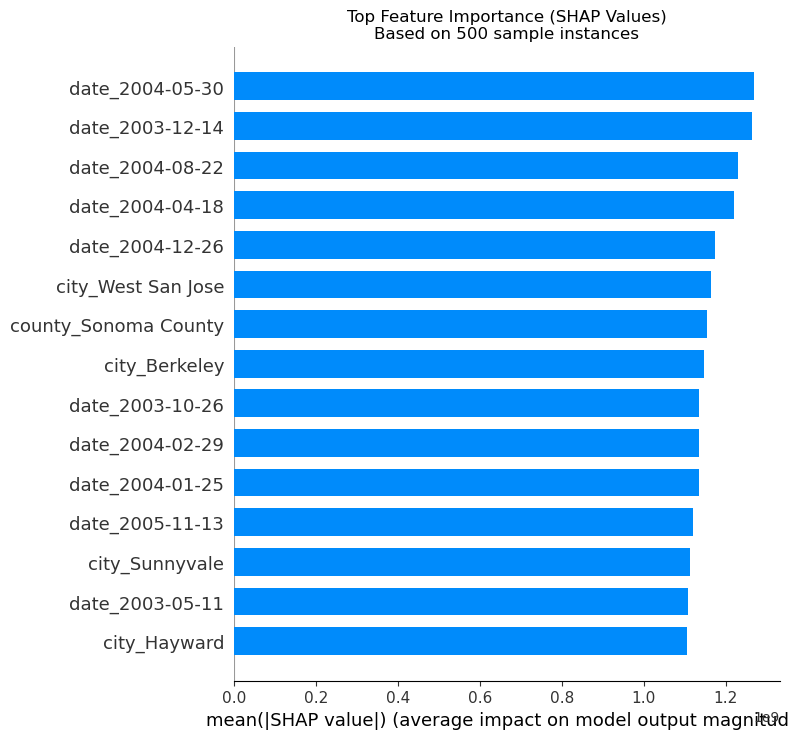

In [23]:
# Prepare data for SHAP with optimizations
try:
    # 1. Use a representative sample (100-500 instances)
    sample_size = min(500, len(X_test))
    sample_idx = np.random.choice(X_test.index, size=sample_size, replace=False)
    X_sample = X_test.loc[sample_idx]
    
    # 2. Precompute transformed data
    X_sample_transformed = rf_pipeline.named_steps['preprocessor'].transform(X_sample)
    
    # 3. Get feature names
    encoder = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']
    encoded_cats = encoder.get_feature_names_out(categorical_cols)
    all_features = numeric_cols + list(encoded_cats)
    
    # 4. Create explainer with feature perturbation (faster than tree_path_dependent)
    explainer = shap.TreeExplainer(
        rf_pipeline.named_steps['model'],
        feature_perturbation="interventional",  # Faster approximation
        data=None  # Don't pass background data for speed
    )
    
    # 5. Calculate SHAP values with fewer samples
    shap_values = explainer.shap_values(
        X_sample_transformed,
        check_additivity=False  # Slight speed boost
    )
    
    # 6. Create efficient visualization
    plt.figure(figsize=(12, 6))
    shap.summary_plot(
        shap_values, 
        X_sample_transformed,
        feature_names=all_features,
        plot_type="bar",
        show=False,
        max_display=15  # Show only top 15 features
    )
    plt.title(f'Top Feature Importance (SHAP Values)\nBased on {sample_size} sample instances')
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Could not create SHAP plot: {e}")


=== Price Prediction Ratio by County ===
county
Marin county             0.719796
San Mateo county         0.967496
Marin County             1.018021
San Francisco County     1.026605
Santa Clara County       1.030232
Alpine County            1.032618
Santa Clara county       1.032682
Alameda County           1.035464
Contra Costa county      1.043594
Sonoma County            1.047738
San Mateo County         1.056498
Contra Costa County      1.057312
San Franciscoe county    1.057322
Solano County            1.061977
Alameda county           1.064680
Napa County              1.065194
Sonoma county            1.091604
San Francisco county     1.133935
Solano county            1.137941
Napa county              1.236662
San Franciscoe County    1.344933
Name: price_ratio, dtype: float64


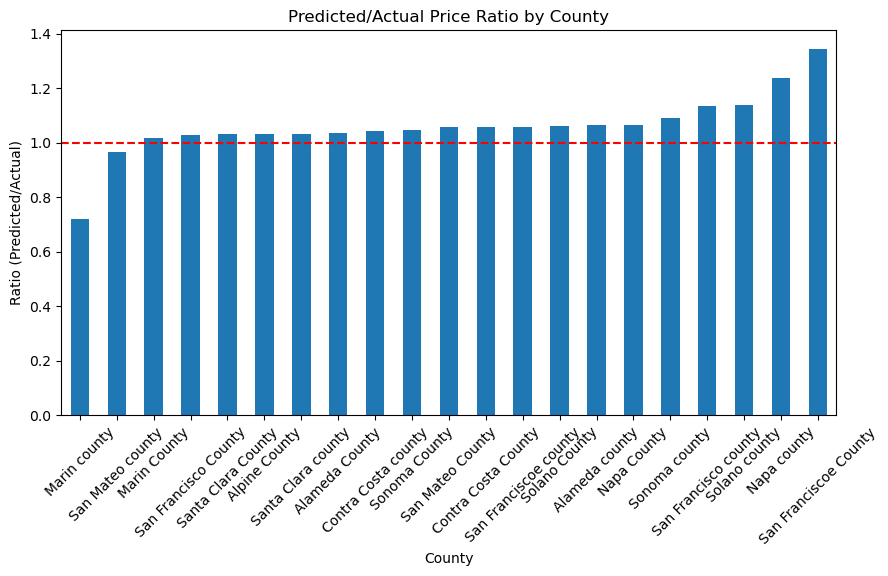

In [48]:
# 7. Ethical Considerations Analysis
X_test_copy = X_test.copy()
X_test_copy['predicted_price'] = rf_pipeline.predict(X_test)
X_test_copy['actual_price'] = y_test
X_test_copy['price_ratio'] = X_test_copy['predicted_price'] / X_test_copy['actual_price']

price_ratio_by_county = X_test_copy.groupby('county')['price_ratio'].mean().sort_values()
print("\n=== Price Prediction Ratio by County ===")
print(price_ratio_by_county)

plt.figure(figsize=(10, 5))
price_ratio_by_county.plot(kind='bar')
plt.axhline(1, color='red', linestyle='--')
plt.title('Predicted/Actual Price Ratio by County')
plt.ylabel('Ratio (Predicted/Actual)')
plt.xlabel('County')
plt.xticks(rotation=45)
plt.show()